# k-means算法解释    

### 一、引用的包和中文绘图设置

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import time

# 设置图像中文字体为黑体
mpl.rc("font", family="SimHei")
# 解决坐标轴负号不显示
mpl.rcParams['axes.unicode_minus'] = False

## 二、定义

### 1. 计算两点欧式距离的平方  
为了代码简洁, 定义欧式距离的平方:

In [2]:
def dist(a, b):
    """ a和b点的距离的平方 """
    return np.dot(a - b, a - b)

### 2. 集合`k-means`算法:

#### 数据的初始化  
1. 令聚类个数$k=5$, 数据样本量$n=100$且都是二维数据,
1. 接下来生成样本矩阵, 其中矩阵每一行代表一个数据, 前两列代表数据的横纵坐标, 第三列代表数据的标签, 初始化为-1.

#### 迭代  
设置距离矩阵, 初始化为0, 然后以500为迭代次数进行迭代, 在每一次迭代中:  
1. 先计算每个样本与均值向量的距离, 更新距离矩阵,
2. 再进行分类, 将每个点标签更新为距离最近的均值向量的编号,
3. 最后更新均值向量, 将取每一个新聚簇中的点的均值, 之后不断迭代, 直到达到次数.

#### 损失函数  
损失函数定义为每个点到对应聚簇均值向量的距离的平方和.

#### 可视化  
最后利用`matplotlib`库将结果可视化:

In [3]:
class kmean():
    """ k均值算法 """
    
    def __init__(self, k=5, n=100):
        """ k均值数据生成和初值选取 """
        # 聚类k个数和数据n个数
        self.k = k
        self.n = n
        # 生成的数据矩阵,最后一列是点的标签
        self.data = np.random.randn(self.n, 3) * 10
        for i in range(0, self.n):
            self.data[i, 2] = -1
        # 选取初始向量
        mu = np.random.randint(low=0, high=self.n, size=self.k)
        self.mean = np.full((self.k, 2), 0.0)
        for i in range(0, self.k):
            for j in [0, 1]:
                self.mean[i, j] = self.data[mu[i], j]

    def iteration(self):
        """ 迭代 """
        # 点到均值向量的距离矩阵
        self.distm = np.full((self.n, self.k), 0.0)
        # 迭代
        iter = 500
        for t in range(0, iter):
            # 计算距离
            for i in range(0, self.n):
                for j in range(0, self.k):
                    self.distm[i, j] = dist(self.data[i, 0:2], self.mean[j, :])
            # 分类
            for i in range(0, self.n):
                self.data[i, 2] = np.argmin(self.distm[i, :])
            # 更新均值向量
            for i in range(0, self.k):
                smean = (0.0, 0.0)
                num = 0
                for j in range(0, self.n):
                    if self.data[j, 2] == i:
                        smean = smean + self.data[j, 0:2]
                        num = num + 1
                if num != 0:
                    self.mean[i, :] = [i / num for i in smean]

    def Loss(self):
        """ 损失函数值 """
        loss = 0
        for i in range(0, self.k):
            for j in range(0, self.n):
                if self.data[j, 2] == i:
                    loss = loss + dist(self.data[j, 0:2], self.mean[i, :])
        print("原损失函数值: ", loss)

    def kmeanplt(self):
        """ 数据可视化 """
        colors = ['red', 'green', 'blue', 'purple', 'yellow']
        for i in range(0, self.k):
            x = []
            y = []
            for j in range(0, self.n):
                if self.data[j, 2] == i:
                    x.append(self.data[j, 0])
                    y.append(self.data[j, 1])
            plt.scatter(x, y, c=colors[i], s=10)
            plt.scatter(self.mean[i, 0], self.mean[i, 1], c=colors[i], s=100)
        plt.title("原k均值分类结果")
        plt.savefig("C:/Users/Zhang/Desktop/原k均值结果.pdf")
        plt.show()

## 三、程序实验  
在调用程序同时, 计算运行时间并打印:

原损失函数值:  6010.06484295899
运行时间: 0.8802409172058105 s


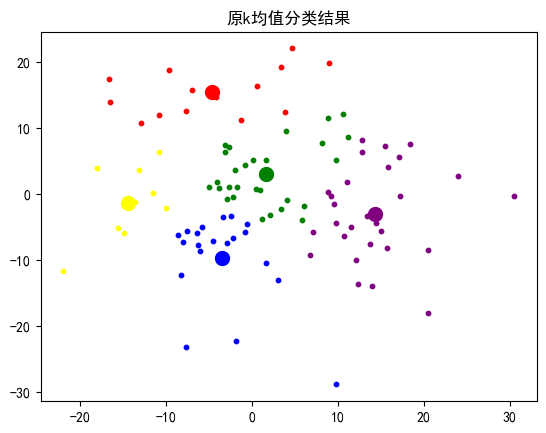

In [4]:
# 开始计算时间
start = time.time()
test = kmean()
test.iteration()
# 结束计算时间
end = time.time()
test.Loss()
print('运行时间: ' + str(end - start) + ' s')
test.kmeanplt()

# k-means改进算法解释  
首先引入额外需要的包、类和函数

In [5]:
import random as rand
import math
import kmeans
from kmeans import dist

改进算法基于模拟退火, 在算法开始进行`k-means`迭代, 得到一个初始解, 然后温度从高到低等比下降, 在每一个温度下进行迭代, 在每一次迭代时, 随机选取点, 将点的标签随机修改为其他的聚簇, 然后计算损失函数,  损失函数为均方误差函数. 

In [6]:
def sqdLoss(data, mean, k=5, n=100):
    """ 均方损失函数值 """
    loss = 0
    for i in range(0, k):
        for j in range(0, n):
            if data[j, 2] == i:
                loss = loss + dist(data[j, 0:2], mean[i, :])
    return loss

当损失函数值优于(即小于)原损失函数值, 那么接受新解为当前解, 否则, 按照Metropolis准则接受, Metrololis准则为

In [7]:
def Metropolis(former, latter, t):
    """ 按照Metropolis准则输出1 """
    x = rand.uniform(0, 1)
    cumulative_probability = 0.0
    prob = math.exp(-(latter - former) / t)
    for item, item_probability in zip([1, 0], [prob, 1 - prob]):
        cumulative_probability += item_probability
        if x < cumulative_probability:
            break
    return item

当准则接受较差的新解时, 进行次数较少的k-means迭代. 最后不断迭代, 直到温度达到终止温度. 将最后的结果与初始解比较, 若优于, 则选择新解, 否则不选择.

In [10]:
class impkmeans():
    """ 模拟退火改进k均值算法 """

    def __init__(self):
        """ 生成初始解 """
        # 进行一次k均值迭代生成初始解
        former = kmeans.kmean()  # type: ignore
        former.iteration()
        former.Loss()
        former.kmeanplt()
        self.data = former.data
        self.k = former.k
        self.n = former.n
        self.mean = former.mean
        self.distm = former.distm

    def iteration(self):
        """ 迭代 """
        # 记录初始解
        initdata = self.data
        initmean = self.mean
        initdistm = self.distm
        initloss = sqdLoss(initdata, initmean)
        # 初始温度、退火因子和终止温度
        T = 100
        Ttermi = 0.01
        x = 0.95
        # 扰动点的数量
        change = 50
        # 迭代次数
        iteration = 10
        while T >= Ttermi:
            for iter in range(0, iteration):
                # 随机扰动后的样本和均值向量
                testdata = self.data
                testmean = self.mean
                testdistm = self.distm
                # 随机选取扰动点
                randot = np.random.randint(low=0, high=self.n, size=change)
                # 将扰动点随机分配给其他类
                for i in randot:
                    while True:
                        choice = rand.choice(np.linspace(
                            0, self.k - 1, self.k))
                        if choice != self.data[i, 2]:
                            testdata[i, 2] = choice
                            break
                # 更新均值向量
                for i in range(0, self.k):
                    smean = (0.0, 0.0)
                    num = 0
                    for j in range(0, self.n):
                        if testdata[j, 2] == i:
                            smean = smean + testdata[j, 0:2]
                            num = num + 1
                    if num != 0:
                        testmean[i, :] = [i / num for i in smean]
                # 重新计算距离
                for i in range(0, self.n):
                    for j in range(0, self.k):
                        testdistm[i, j] = dist(testdata[i, 0:2],
                                               testmean[j, :])
                # 计算损失函数
                loss = sqdLoss(self.data, self.mean)
                testloss = sqdLoss(testdata, testmean)
                # 随机扰动的结果优于现结果
                if testloss < loss:
                    self.data = testdata
                    self.mean = testmean
                    self.distm = testdistm
                # 随机扰动结果不优于现结果
                elif Metropolis(loss, testloss, T) == 1:
                    # 按Metropolis准则接受现结果
                    self.data = testdata
                    self.mean = testmean
                    self.distm = testdistm
                    # 重新k均值迭代
                    iiter = 100
                    for t in range(0, iiter):
                        # 计算距离
                        for i in range(0, self.n):
                            for j in range(0, self.k):
                                self.distm[i,
                                           j] = dist(self.data[i, 0:2],
                                                     self.mean[j, :])
                        # 分类
                        for i in range(0, self.n):
                            self.data[i, 2] = np.argmin(self.distm[i, :])
                        # 更新均值向量
                        for i in range(0, self.k):
                            smean = (0.0, 0.0)
                            num = 0
                            for j in range(0, self.n):
                                if self.data[j, 2] == i:
                                    smean = smean + self.data[j, 0:2]
                                    num = num + 1
                            if num != 0:
                                self.mean[i, :] = [i / num for i in smean]
            T = T * x
        # 迭代完成后, 若优于初始解则采用, 否则不采用
        loss = sqdLoss(self.data, self.mean)
        if initloss < loss:
            self.data = initdata
            self.mean = initmean
            self.distm = initdistm

    def Loss(self):
        """ 损失函数值 """
        print("改进损失函数值: ", sqdLoss(self.data, self.mean))

    def impkmeanplt(self):
        """ 数据可视化 """
        colors = ['red', 'green', 'blue', 'purple', 'yellow']
        for i in range(0, self.k):
            x = []
            y = []
            for j in range(0, self.n):
                if self.data[j, 2] == i:
                    x.append(self.data[j, 0])
                    y.append(self.data[j, 1])
            plt.scatter(x, y, c=colors[i], s=10)
            plt.scatter(self.mean[i, 0], self.mean[i, 1], c=colors[i], s=100)
        plt.title("改进k均值分类结果")
        plt.savefig("C:/Users/Zhang/Desktop/改进k均值结果.pdf")
        plt.show()


选取一个实例进行展示

原损失函数值:  5785.35671664739


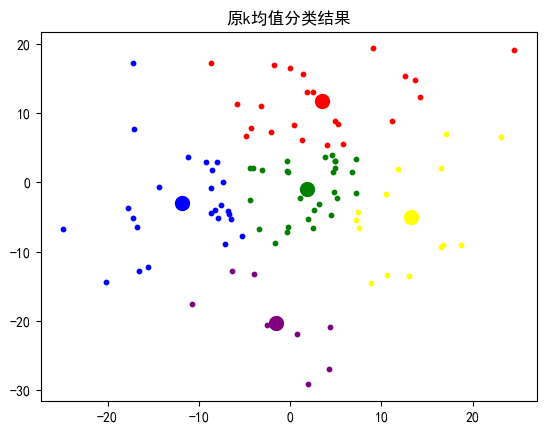

改进损失函数值:  5564.270314614856
运行时间: 325.42120814323425 s


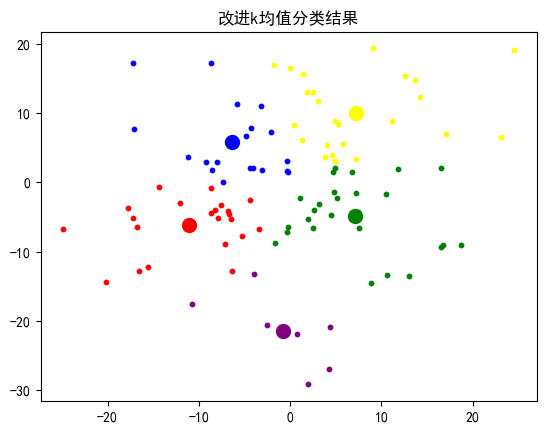

In [11]:
# 开始计算时间
start = time.time()
test = impkmeans()
test.iteration()
# 结束计算时间
end = time.time()
test.Loss()
print('运行时间: ' + str(end - start) + ' s')
test.impkmeanplt()